In [1]:
import xarray as xr
import vtk
import rasterio 
from rasterio import features

from RWP_identification_functions import addMaxData
from RWP_identification_functions import interpolateCellVals
from RWP_identification_functions import clipDataset
from RWP_identification_functions import addConnectivityData
from RWP_identification_functions import extractPosMaxIds
from RWP_identification_functions import extractSelectionIds
from RWP_identification_functions import clusterMax
from RWP_identification_functions import max_cluster_assign

from RWP_identification_functions import addMinData
from RWP_identification_functions import interpolateCellVals_min
from RWP_identification_functions import clipDataset_min
from RWP_identification_functions import addConnectivityData_min
from RWP_identification_functions import extractPosMinIds
from RWP_identification_functions import extractSelectionIds_min
from RWP_identification_functions import clusterMin
from RWP_identification_functions import min_cluster_assign

from RWP_identification_functions import computeGradients
from RWP_identification_functions import getIsoContour
from RWP_identification_functions import computeAssocGraph
from RWP_identification_functions import scalarPrune
from RWP_identification_functions import edgePrune
from RWP_identification_functions import GetRankedPaths

from RWP_identification_functions import plot_points
from RWP_identification_functions import plot_clusters
from RWP_identification_functions import all_clusters
from RWP_identification_functions import plot_graph
from RWP_identification_functions import plot_ranked_graph

In [2]:
from collections import defaultdict
import pandas as pd
from shapely.ops import unary_union
import numpy as np
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from myCmap import joyNLDivCmaptest
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import cmocean
from matplotlib.gridspec import GridSpec

import shapely
from shapely.geometry import MultiPoint
from shapely.geometry import Polygon
from shapely.geometry import LineString
import sys
from descartes import PolygonPatch
import matplotlib.pyplot as plt
import alphashape
import matplotlib.cm as cm
from matplotlib.colors import Normalize

In [3]:
from operator import add
from functools import reduce
import networkx as nx
import sys

# function to split input raster image into 4 equal images 
# returns the 4 split images 

def split4(image):
    half_split = np.array_split(image, 2)
    res = map(lambda x: np.array_split(x, 2, axis=1), half_split)
    return reduce(add, res)

# function to compute mean pixel value of an image
# returns mean value for each image

def calculate_mean(img):
    return np.mean(img, axis=(0, 1))

# function to return all the features (in terms of pixel value assigned to each feature) present in an image
def feature(image,array):
    f=[]
    r,c = image.shape
    for i in range(len(array)):
        for j in range(r):
            for k in range(c):
                if(array[i] == image[j][k]):
                    if(array[i] not in f):
                        f.append(array[i])
                elif(image[j][k]==0):
                    if(0 not in f):
                        f.append(0)
    f = np.array(f)                
    return f
    

# function to create a quadtree corresponding to a raster image. Initial node i=0 is created beforehand and passed on as an argument
# i represents the position of a node in the raster image. Between 2 quadtrees, nodes with the same i value represents the same position within their respective raster images
# level represents the height at which a particular node is located in a quadtree. It serves as a pointer to the dimensions of a node (how many pixels it contains)
# the function returns the constructed quadtree Q; nodes are given by their i values and each node consists of the mean of the pixel values, features it contains and the height/level at which the node is located

def insert_node(Q,i,image,value,level):
    r,c = np.array(image).shape
    if(r>1 and c>1):
        level = level+1
        split_img = split4(image)
        split_img = np.array(split_img)

        m_1 = calculate_mean(split_img[0])
        f_1 = feature(split_img[0],a[value])
        Q.add_node((4*i)+1,mean = m_1, f = f_1,level = level)
        Q.add_edge(i,(4*i)+1)

        m_2 = calculate_mean(split_img[1]) 
        f_2 = feature(split_img[1],a[value])
        Q.add_node((4*i)+2,mean = m_1, f = f_2,level = level)
        Q.add_edge(i,(4*i)+2)

        m_3 = calculate_mean(split_img[2])
        f_3 = feature(split_img[2],a[value])
        Q.add_node((4*i)+3,mean = m_1, f = f_3,level = level)
        Q.add_edge(i,(4*i)+3)

        m_4 = calculate_mean(split_img[3])
        f_4 = feature(split_img[3],a[value])
        Q.add_node((4*i)+4,mean = m_1, f = f_4,level = level)
        Q.add_edge(i,(4*i)+4)

        if(len(f_1)>1):
            Q = insert_node(Q,(4*i)+1,split_img[0],value,level)

        if(len(f_2)>1):
            Q = insert_node(Q,(4*i)+2,split_img[1],value,level)

        if(len(f_3)>1):
            Q = insert_node(Q,(4*i)+3,split_img[2],value,level)

        if(len(f_4)>1):
            Q = insert_node(Q,(4*i)+4,split_img[3],value,level)


    return Q


In [4]:
# function to compute the number of pixels corresponding to each feature in a particular quadtree
# returns a dictionary "pixel_dict" whose - key:feature values, values:number of pixels 

def compute_pixels(Q):
    pixel_dict = defaultdict(list)
    leaf_nodes = [node for node in Q.nodes() if Q.in_degree(node)!=0 and Q.out_degree(node)==0]
    for i in range(len(leaf_nodes)):
        f = Q.nodes[leaf_nodes[i]]["f"]
        f = tuple(f)
        if(0 in f):
            continue
        if(f in pixel_dict):
            pixel_dict[f]+=(262144/(4**(Q.nodes[leaf_nodes[i]]["level"])))
        else:
            pixel_dict[f]=(262144/(4**(Q.nodes[leaf_nodes[i]]["level"])))
    return pixel_dict

In [5]:
import math

# function to construct a certain branch of the merge quadtree
# Used when in a particular location, the feature in one quadtree is bigger in size compared to the feature in the second quadtree
# G represents quadtree who has the smaller feature; i is the leaf node(feature node) in the other quadtree
# Returns merged quadtree Q with the branch rooted at i same as that of the input quadtree G

def construct(Q,G,i,h):
    for j in range(1,5):
        if((len(G.nodes[(4*i)+j]["f"])==1) and (G.nodes[(4*i)+j]["f"][0]==0)):
            Q.add_node((4*i)+j, f=[0], level = G.nodes[(4*i)+j]["level"])
        else:
            Q.add_node((4*i)+j, f=np.sort(np.concatenate([G.nodes[(4*i)+j]["f"],h])), level = G.nodes[(4*i)+j]["level"])
        Q.add_edge(i,(4*i)+j)
    for j in range(1,5):
        if(len(G.nodes[(4*i)+j]["f"])>1):
            Q = construct(Q,G,(4*i)+j,h)
    return Q
        
# function to merge two quadtrees G and H; Q represents the merged quadtree
# returns the merged quadtree Q

def merge(G,H):
    Q = nx.DiGraph()
    i = 0
    while(i<=332124):
        if i not in list(Q):
            if i in list(G):
                if i in list(H):
                    if((len(G.nodes[i]["f"])==1 and G.nodes[i]["f"][0]==0) or ((len(H.nodes[i]["f"])==1 and (H.nodes[i]["f"][0]==0)))):
                        Q.add_node(i, f=[0], level = G.nodes[i]["level"])
                        if(math.ceil((i/4)-1)>=0):
                            Q.add_edge(math.ceil((i/4)-1),i) 
                    if((len(G.nodes[i]["f"])>1) and ((len(H.nodes[i]["f"])==1) and (H.nodes[i]["f"]!=0))):
                        Q = construct(Q,G,i,H.nodes[i]["f"])
                    if((len(H.nodes[i]["f"])>1) and ((len(G.nodes[i]["f"])==1) and (G.nodes[i]["f"]!=0))):
                        Q = construct(Q,H,i,G.nodes[i]["f"])
                    else:
                        f = np.concatenate([G.nodes[i]["f"],H.nodes[i]["f"]])
                        Q.add_node(i, f=np.sort(f), level = G.nodes[i]["level"])
                        if(math.ceil((i/4)-1)>=0):
                            Q.add_edge(math.ceil((i/4)-1),i)
        i = i+1
    return Q

In [6]:
image = []
Q = []
final = []
assoc = []

reached


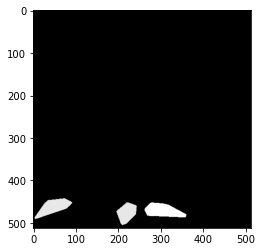

reached


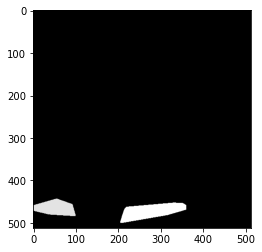

reached


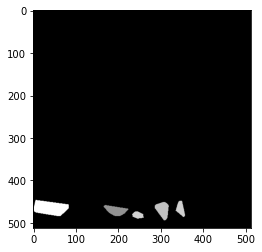

reached


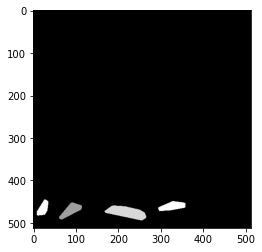

reached


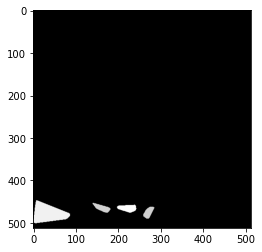

reached


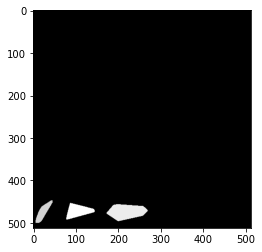

reached


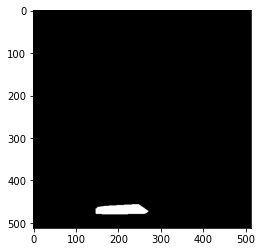

reached


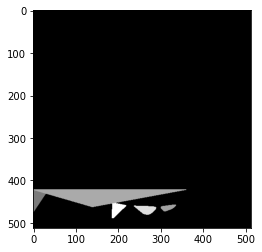

reached


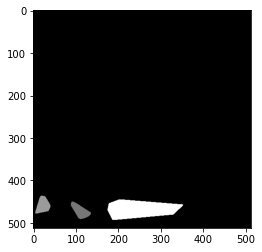

reached


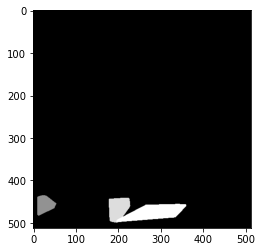

reached


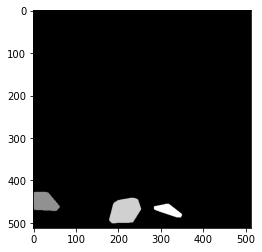

reached


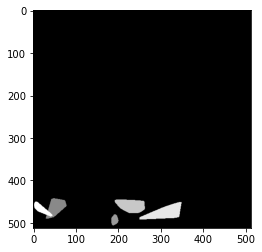

reached


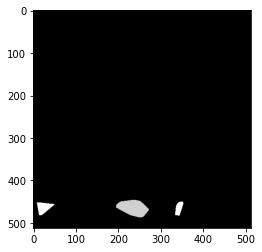

reached


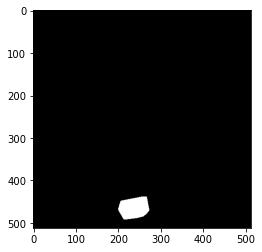

reached


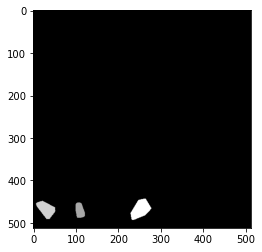

In [7]:
# computes raster images corresponding to the given timesteps (0-14 in this case) of the dataset
# first we identify representative RWP paths for each timestep (ranked_paths_graph)
# we then construct convex hulls around these identified RWPs using the 0.5 * maximum of the v-values in that component
# poly_list consists of all such convex hulls for a particular timestep
# these polygons and then rasterised; "image" is an array that consists of raster images of all timesteps
# coords_dict respresents the weighted average coordinates corresponding to each convex hull

dataDIR = 'Downloads/Case_1_revised.nc'
DS = xr.open_dataset(dataDIR)
coords_dict = defaultdict(list)
centroid_dict = defaultdict(list)
polygon_dict = defaultdict(list)

for timestep in range(0,15):
    da = DS.v[timestep]
    scalar_values = da.values
    lon1 = DS.longitude
    lat1 = DS.latitude
    lon = lon1.values
    lat = lat1.values

    rect,is_max = addMaxData(lat,lon,scalar_values)
    scalar_field = interpolateCellVals(rect)
    clip_value_max = 2
    clipped_scalar_field = clipDataset(scalar_field, "v", clip_value_max)
    connectivity_clipped_scalar_field = addConnectivityData(clipped_scalar_field)
    max_thresh = 5
    max_points = extractSelectionIds(connectivity_clipped_scalar_field,
                                     extractPosMaxIds(connectivity_clipped_scalar_field,max_thresh))
    max_points = clusterMax(scalar_field, connectivity_clipped_scalar_field, max_points)
    cluster_max_arr,cluster_max_point,max_pt_dict,num_max_clusters = max_cluster_assign(max_points)



    scalar_field1,is_min = addMinData(lat,lon,scalar_values)
    scalar_field1 = interpolateCellVals_min(scalar_field1)
    clip_value_min = -2
    clipped_scalar_field1 = clipDataset_min(scalar_field1, "v", clip_value_min)
    connectivity_clipped_scalar_field1 = addConnectivityData_min(clipped_scalar_field1)
    min_thresh = -5
    min_points = extractSelectionIds_min(connectivity_clipped_scalar_field1, extractPosMinIds(
        connectivity_clipped_scalar_field1,min_thresh))
    min_points = clusterMin(scalar_field1, connectivity_clipped_scalar_field1, min_points)
    cluster_min_arr,cluster_min_point,min_pt_dict,num_min_clusters = min_cluster_assign(min_points)


    scalar_field = computeGradients(rect)
    zero_contour = getIsoContour(scalar_field, 0.0)
    assoc_graph = computeAssocGraph(max_points, min_points, zero_contour)
    pruned_assoc_graph_scalar = scalarPrune(assoc_graph, 30)
    pruned_assoc_graph_edge = edgePrune(pruned_assoc_graph_scalar, 0.02)
    ranked_paths_graph = GetRankedPaths(pruned_assoc_graph_edge)
    assoc.append(assoc_graph)
    final.append(ranked_paths_graph)

    abs_max_dict = defaultdict(list)
    poly_dict = defaultdict(list)
    poly_list = []
    
    
    for i in range(len(ranked_paths_graph)):
        max_value = 0
        coord = [0,0]
        weight = 0
        for j in range(len(ranked_paths_graph[i])):
            
            coord[0]+=abs(pruned_assoc_graph_edge.nodes[ranked_paths_graph[i][j]]["scalar"])*pruned_assoc_graph_edge.nodes[ranked_paths_graph[i][j]]["coords"][0]
            coord[1]+=abs(pruned_assoc_graph_edge.nodes[ranked_paths_graph[i][j]]["scalar"])*pruned_assoc_graph_edge.nodes[ranked_paths_graph[i][j]]["coords"][1]
            weight+=abs(pruned_assoc_graph_edge.nodes[ranked_paths_graph[i][j]]["scalar"])
            
            if(ranked_paths_graph[i][j]<0):
                if(max_value < -assoc_graph.nodes[ranked_paths_graph[i][j]]["scalar"]):
                    max_value = -assoc_graph.nodes[ranked_paths_graph[i][j]]["scalar"]
                    
            else:
                if(max_value < assoc_graph.nodes[ranked_paths_graph[i][j]]["scalar"]): 
                    max_value = assoc_graph.nodes[ranked_paths_graph[i][j]]["scalar"]
                    
        
        abs_max_dict[i] = round(max_value,2)
        scalar = 0.5*max_value
        coords_dict[abs_max_dict[i]]=[coord[0]/weight,coord[1]/weight]

        clip_max = clipDataset(rect,"v",scalar)
        connected_max = addConnectivityData(clip_max)
        region_id_max = connected_max.GetPointData().GetArray("RegionId")

        clip_min = clipDataset_min(rect,"v",-scalar)
        connected_min = addConnectivityData_min(clip_min)
        region_id_min = connected_min.GetPointData().GetArray("RegionId")

        MaxLocator=vtk.vtkPointLocator()
        MaxLocator.SetDataSet(connected_max)
        MaxLocator.BuildLocator()

        MinLocator=vtk.vtkPointLocator()
        MinLocator.SetDataSet(connected_min)
        MinLocator.BuildLocator()

        for j in range(len(ranked_paths_graph[i])):
            
            if(ranked_paths_graph[i][j] >= 0):
                x,y = pruned_assoc_graph_edge.nodes[ranked_paths_graph[i][j]]["coords"]
                coords = [x,y,0.0]
                #print(coords)
                iD = MaxLocator.FindClosestPoint(coords)
                region_id = region_id_max.GetTuple1(iD)
                #print(region_id)
                for k in range(connected_max.GetNumberOfPoints()):
                    if(region_id_max.GetTuple1(k) == region_id):
                        coords = [connected_max.GetPoint(k)[0],connected_max.GetPoint(k)[1]]
                        poly_dict[i].append(coords)


            if(ranked_paths_graph[i][j] < 0):
                x,y = pruned_assoc_graph_edge.nodes[ranked_paths_graph[i][j]]["coords"]
                coords = [x,y,0.0]
                iD = MinLocator.FindClosestPoint(coords)
                region_id = region_id_min.GetTuple1(iD)
                for k in range(connected_min.GetNumberOfPoints()):
                    if(region_id_min.GetTuple1(k) == region_id):
                        coords = [connected_min.GetPoint(k)[0],connected_min.GetPoint(k)[1]]
                        poly_dict[i].append(coords)                    
        
        
        
    for i in range(len(poly_dict)):
        simple = MultiPoint(poly_dict[i]).convex_hull
        poly_list.append([simple,abs_max_dict[i]])
        polygon_dict[abs_max_dict[i]]=simple
    
    print("reached")
    img = features.rasterize(((g,i) for g,i in poly_list),out_shape = (512,512),all_touched = True)
    image.append(img[::-1])
    plt.imshow(img[::-1])
    plt.gray()
    plt.show()
    

In [8]:
coords_dict

defaultdict(list,
            {60.8: [304.1485499560071, 40.73623951848549],
             55.14: [43.05601320783904, 47.9521735483612],
             54.9: [221.22951460839616, 29.502171561663605],
             64.28: [45.768065528879035, 46.532399900446364],
             72.17: [277.1901714590542, 40.10244022019268],
             50.17: [305.2627434430373, 40.32062153913724],
             38.35: [188.3865578118197, 41.726588080153036],
             66.08: [42.74884055365892, 43.39630828456551],
             54.78: [249.6526605463, 27.75],
             53.74: [347.37437930201963, 46.76056898751953],
             61.11: [328.28445884901964, 50.59339448662914],
             51.69: [227.37811795055325, 34.62562520597293],
             60.52: [19.708197566093958, 36.39909422444083],
             38.13: [90.91686135940644, 42.24150558479606],
             50.26: [37.717417837586765, 32.72410265936334],
             53.29: [220.48397411294115, 45.84459041698709],
             43.44: [266.0178

In [9]:
# a is a an array whose elements are arrays of features present in each timestep
# each element of a is an array which consists of the pixel values representing features in that particular timestep 

a = []
for k in range(len(image)):
    b = []
    for i in range(len(image[k])):
        for j in range(len(image[k][i])):
            if(image[k][i][j]>=1):
                if image[k][i][j] not in b: 
                    b.append(image[k][i][j])
    b.sort(reverse = True)
    a.append(b)
print(a)

[[60.8, 55.14, 54.9], [72.17, 64.28], [66.08, 54.78, 53.74, 50.17, 38.35], [61.11, 60.52, 51.69, 38.13], [53.29, 50.26, 43.86, 43.44], [51.8, 47.91, 43.08], [70.49], [68.73, 60.09, 45.72, 43.6, 33.19], [75.65, 46.08, 35.32], [68.14, 58.92, 38.96], [66.03, 53.86, 37.45], [63.84, 57.79, 50.04, 38.88, 34.41], [58.44, 58.32, 47.58], [46.36], [52.59, 42.97, 34.6]]


In [10]:
# creating quadtrees for each raster image
# Q is an array that consists of quadtrees for all timesteps

for i in range(len(image)):
    Q1 = nx.DiGraph()
    m = calculate_mean(image[i])
    Q1.add_node(0, mean = m, f = feature(image[i],a[i]),level = 0)
    Q1 = insert_node(Q1,0,image[i],i,0)
    Q.append(Q1)

In [11]:
# Track is a tracking graph that consists of feature nodes (pixel values of each feature) for each timestep and edges between every feature that overlaps between consecutive timesteps

from itertools import product

Track = nx.Graph()
for i in range(len(a)):
    for j in range(len(a[i])):
        Track.add_node(a[i][j],layer = i)
    if(i>0):
        edge_list = list(product(a[i],a[i-1]))
        merge_graph = merge(Q[i],Q[i-1])
        overlap = compute_pixels(merge_graph)
        for e in edge_list:
            if e in overlap:
                print(e,overlap[e])
                Track.add_edge(e[0],e[1])
            if e[::-1] in overlap:
                print(e[::-1],overlap[e[::-1]])
                Track.add_edge(e[0],e[1])


(60.8, 72.17) 1732.0
(54.9, 72.17) 958.0
(55.14, 64.28) 1432.0
(64.28, 66.08) 1914.0
(54.78, 72.17) 319.0
(53.74, 72.17) 296.0
(50.17, 72.17) 760.0
(38.35, 72.17) 93.0
(53.74, 61.11) 197.0
(50.17, 61.11) 306.0
(60.52, 66.08) 540.0
(51.69, 54.78) 319.0
(38.35, 51.69) 510.0
(38.13, 66.08) 89.0
(51.69, 53.29) 431.0
(50.26, 60.52) 492.0
(38.13, 50.26) 296.0
(43.86, 51.69) 94.0
(43.44, 51.69) 42.0
(50.26, 51.8) 82.0
(47.91, 53.29) 596.0
(43.86, 47.91) 22.0
(43.44, 47.91) 51.0
(43.08, 50.26) 695.0
(47.91, 70.49) 1706.0
(68.73, 70.49) 511.0
(60.09, 70.49) 335.0
(68.73, 75.65) 642.0
(60.09, 75.65) 728.0
(45.72, 75.65) 189.0
(43.6, 75.65) 357.0
(33.19, 46.08) 142.0
(68.14, 75.65) 3058.0
(58.92, 75.65) 1559.0
(38.96, 46.08) 690.0
(66.03, 68.14) 1038.0
(53.86, 68.14) 825.0
(53.86, 58.92) 1689.0
(37.45, 38.96) 1260.0
(37.45, 63.84) 350.0
(57.79, 66.03) 786.0
(50.04, 53.86) 1203.0
(38.88, 53.86) 270.0
(34.41, 37.45) 458.0
(57.79, 58.44) 336.0
(58.32, 63.84) 322.0
(34.41, 58.32) 90.0
(47.58, 57.79) 

In [12]:
Track.edges()

EdgeView([(60.8, 72.17), (55.14, 64.28), (54.9, 72.17), (72.17, 54.78), (72.17, 53.74), (72.17, 50.17), (72.17, 38.35), (64.28, 66.08), (66.08, 60.52), (66.08, 38.13), (54.78, 51.69), (53.74, 61.11), (50.17, 61.11), (38.35, 51.69), (60.52, 50.26), (51.69, 53.29), (51.69, 43.86), (51.69, 43.44), (38.13, 50.26), (53.29, 47.91), (50.26, 51.8), (50.26, 43.08), (43.86, 47.91), (43.44, 47.91), (47.91, 70.49), (70.49, 68.73), (70.49, 60.09), (68.73, 75.65), (60.09, 75.65), (45.72, 75.65), (43.6, 75.65), (33.19, 46.08), (75.65, 68.14), (75.65, 58.92), (46.08, 38.96), (68.14, 66.03), (68.14, 53.86), (58.92, 53.86), (38.96, 37.45), (66.03, 57.79), (53.86, 50.04), (53.86, 38.88), (37.45, 63.84), (37.45, 34.41), (63.84, 58.32), (57.79, 58.44), (57.79, 47.58), (50.04, 47.58), (34.41, 58.32), (47.58, 46.36), (46.36, 52.59)])

In [13]:
# function to compute weight based on extent of overlap between the given combination (comb) of features in timestep i+1 and the feature n in timestep i
# returns the weight for the given inputs

def compute_weight(comb,n,i):
    overlap_1 = compute_pixels(Q[i])
    overlap_2 = compute_pixels(Q[i+1])
    merge_q = merge(Q[i],Q[i+1])
    overlap_3 = compute_pixels(merge_q)
    area_1 = overlap_1[(n,)]
    area_2 = 0
    merge_area = 0
    for i in range(len(comb)):
        if (n,comb[i]) in overlap_3:
            merge_area+=overlap_3[(n,comb[i])]
        if (comb[i],n) in overlap_3:
            merge_area+=overlap_3[(comb[i],n)]
        area_2+=overlap_2[(comb[i],)]
    den = max(area_1,area_2)
    num = merge_area
    weight = num/den
    return weight

In [14]:
# to find the combinations with the highest overlap value (classifying events into amalgamations, continuations and bifurcations)
# filter the edges of the tracking graph

import itertools

edge_list = []
for i in range(len(a)-1):
    for j in range(len(a[i])):
        print(a[i][j])
        n_list = []
        max_tuple = tuple()
        max_weight = 0

        for k in Track.neighbors(a[i][j]):
            if k in a[i+1]:
                n_list.append(k)
        for k in range(1,len(n_list)+1):
            for comb in itertools.combinations(n_list,k):
                weight = compute_weight(comb,a[i][j],i)

                if(max_weight < weight):
                    max_weight = weight
                    max_tuple = comb

        for e in Track.edges(a[i][j]):
            print("edge info",e) 
            if (e[1] in max_tuple) and (e[0]==a[i][j]):
                Track[e[0]][e[1]]["weight"] = max_weight
                print("included")
            if (e[1] not in max_tuple) and (e[1] in a[i+1]):
                edge_list.append(e)

print(edge_list)
for e in edge_list:
#   print(e)
    Track.remove_edge(e[0],e[1])
                

60.8
edge info (60.8, 72.17)
included
55.14
edge info (55.14, 64.28)
included
54.9
edge info (54.9, 72.17)
included
72.17
edge info (72.17, 60.8)
edge info (72.17, 54.9)
edge info (72.17, 54.78)
included
edge info (72.17, 53.74)
included
edge info (72.17, 50.17)
included
edge info (72.17, 38.35)
included
64.28
edge info (64.28, 55.14)
edge info (64.28, 66.08)
included
66.08
edge info (66.08, 64.28)
edge info (66.08, 60.52)
included
edge info (66.08, 38.13)
included
54.78
edge info (54.78, 72.17)
edge info (54.78, 51.69)
included
53.74
edge info (53.74, 72.17)
edge info (53.74, 61.11)
included
50.17
edge info (50.17, 72.17)
edge info (50.17, 61.11)
included
38.35
edge info (38.35, 72.17)
edge info (38.35, 51.69)
included
61.11
edge info (61.11, 53.74)
edge info (61.11, 50.17)
60.52
edge info (60.52, 66.08)
edge info (60.52, 50.26)
included
51.69
edge info (51.69, 54.78)
edge info (51.69, 38.35)
edge info (51.69, 53.29)
included
edge info (51.69, 43.86)
included
edge info (51.69, 43.44)


In [15]:
edge_list 

[(57.79, 47.58)]

In [16]:
for e in Track.edges():
    print(e)

(60.8, 72.17)
(55.14, 64.28)
(54.9, 72.17)
(72.17, 54.78)
(72.17, 53.74)
(72.17, 50.17)
(72.17, 38.35)
(64.28, 66.08)
(66.08, 60.52)
(66.08, 38.13)
(54.78, 51.69)
(53.74, 61.11)
(50.17, 61.11)
(38.35, 51.69)
(60.52, 50.26)
(51.69, 53.29)
(51.69, 43.86)
(51.69, 43.44)
(38.13, 50.26)
(53.29, 47.91)
(50.26, 51.8)
(50.26, 43.08)
(43.86, 47.91)
(43.44, 47.91)
(47.91, 70.49)
(70.49, 68.73)
(70.49, 60.09)
(68.73, 75.65)
(60.09, 75.65)
(45.72, 75.65)
(43.6, 75.65)
(33.19, 46.08)
(75.65, 68.14)
(75.65, 58.92)
(46.08, 38.96)
(68.14, 66.03)
(68.14, 53.86)
(58.92, 53.86)
(38.96, 37.45)
(66.03, 57.79)
(53.86, 50.04)
(53.86, 38.88)
(37.45, 63.84)
(37.45, 34.41)
(63.84, 58.32)
(57.79, 58.44)
(50.04, 47.58)
(34.41, 58.32)
(47.58, 46.36)
(46.36, 52.59)
